In [1]:
import os
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage.segmentation import slic
from fast_slic import Slic
from sklearn.cluster import KMeans
from scipy.ndimage import label

from mmseg.datasets.transforms import *
from mmseg.datasets import PascalVOCDataset
from mmengine.structures import PixelData


from mmengine.config import Config, DictAction
from mmengine.runner import Runner
import itertools
import time

from modelscope import (
    snapshot_download, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
)

/opt/conda/envs/mm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-10 14:09:22,938 - modelscope - INFO - PyTorch version 1.13.1+cu117 Found.
2023-11-10 14:09:22,942 - modelscope - INFO - Loading ast index from /root/.cache/modelscope/ast_indexer
2023-11-10 14:09:22,977 - modelscope - INFO - Loading done! Current index file version is 1.9.4, with md5 15e81bede39dd83de9c6d0777d4ba7ab and a total number of 945 components indexed


In [2]:
model_id = 'qwen/Qwen-VL-Chat'
revision = 'v1.0.0'
model_dir = '../Qwen-VL-Chat'
model = AutoModelForCausalLM.from_pretrained(model_dir, device_map="cuda", trust_remote_code=True).eval()
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
if not hasattr(tokenizer, 'model_dir'):
    tokenizer.model_dir = model_dir

The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".


Loading checkpoint shards: 100%|██████████| 10/10 [00:56<00:00,  5.68s/it]


In [57]:
classes=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
        'sofa', 'train', 'tvmonitor']
classes_str = ""
for name in classes:
    classes_str += (name + ", ")
classes_str = classes_str[:-2]


prompt_template = "<img>{}</img>The green mask in the figure covers part of an object, \
please analyze what is the most likely category of this object? Please select from the categories given below: background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor.\
Please distinguish as many categories of objects as possible, and do not be affected by the main objects in the figure."

prompt_template = '<img>{}</img>You are a professional semantic segmentation model. \
In the image, the green glow covers an object or part of an object.\
From the following list: [background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor], \
select the name that you think best represents the object or part of the object category under the green glow (or green mask). \
You can guess the name of the covered object by the following steps: \
1. Think "Is the object under the green glow (or green mask) complete?" \
2. If complete, think "What is the object?" \
3. If not complete, think "What is the complete object of this component?" \
4. Strictly choose your answer from the above list. \
5. If you are not certain with the object under the mask, just reply with "background".'

name2id, id2name = dict(), dict()

for id, class_name in enumerate(classes):
    name2id[class_name] = id
    id2name[id] = class_name
'[' + classes_str + ']'

'[background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor]'

In [5]:
# class FeatureHooker:
#     def __init__(self, layer):
#         self.layer = layer
#         self.fea = None
#         self.handle = None

#         self.register_hook()
    
#     def hook_fn(self, m, fea_in, fea_out):
#         self.fea = fea_out
        
#     def register_hook(self):
#         self.handle = self.layer.register_forward_hook(self.hook_fn)

# hooker = FeatureHooker(layer=model.transformer.visual.transformer.resblocks[47])

feature_l = [None]
def hook_fn(m, fea_in, fea_out):
    feature_l[0] = fea_out.detach().cpu()

handle = model.transformer.visual.transformer.resblocks[47].register_forward_hook(hook_fn)

In [195]:

queries = ['<img>{}</img>Describe this image.'.format(img_path)]
responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
responses

['The image shows two red and white trains on adjacent tracks. The left train is partially visible, while the right train is fully visible, showing its entire length. Both trains have doors and windows, with the right train having two doors and four windows, and the left train having one door and two windows. The trains appear to be old, as they have a vintage feel to them.']

In [58]:
for idx in range(6):
    img_path = '/remote-home/zhangjiacheng/RVP/data/rendered_img/2007_000727/{}.jpg'.format(idx)
    queries = [prompt_template.format(img_path)]
    responses, history = model.chat(tokenizer=tokenizer, queries=queries, history=None)
    print (responses[0])

person
person
tvmonitor
person
background
person


In [320]:
# K-Means Cluter
device = 'cuda:0'
# feature = hooker.fea[:, 0].cpu().float()
feature = feature_l[0][:, 0].float()
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters)
cluster_ids = kmeans.fit_predict(feature)

/opt/conda/envs/mm/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### 整理代码
空岛去除和空缺填补

In [321]:
cluster_ids = np.resize(cluster_ids, (32, 32))
print (cluster_ids.shape)

masks = []
for id in np.unique(cluster_ids):
    print (id)
    mask = (cluster_ids == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks)
pre_masks = masks.clone()
print (masks.shape)

(32, 32)
0
1
2
3
4
5
torch.Size([6, 32, 32])


In [324]:
structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

for mask in masks:
    print (mask.shape)
    l, n = label(mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 3:
            mask[lb == l] = 0
    
    reversed_mask = mask.logical_not()
    l, n = label(reversed_mask, structure=structure)
    for lb in range(1, n + 1):
        if np.sum(lb == l) <= 10:
            # print (lbl)
            mask[lb == l] = 1

cluster_img = np.zeros((448, 448, 3))

img = cv2.imread(img_path)
resized_masks = masks[:, None].repeat(1, 3, 1, 1)
# resized_masks = torch.zeros((masks.shape[0], 3, 448, 448))
# for i in range(32):
#     for j in range(32):
#         if masks[i, j]:
#             resized_masks[..., i*14:(i+1)*14, j*14:(j+1)*14] = 1

resized_masks = TF.resize(resized_masks, (img.shape[0], img.shape[1]), interpolation=InterpolationMode.NEAREST)
# resized_masks = F.interpolate(resized_masks, size=(img.shape[0], img.shape[1]), mode='bilinear', align_corners=False).byte()
resized_masks.shape

torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32, 32])


torch.Size([6, 3, 335, 500])

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])

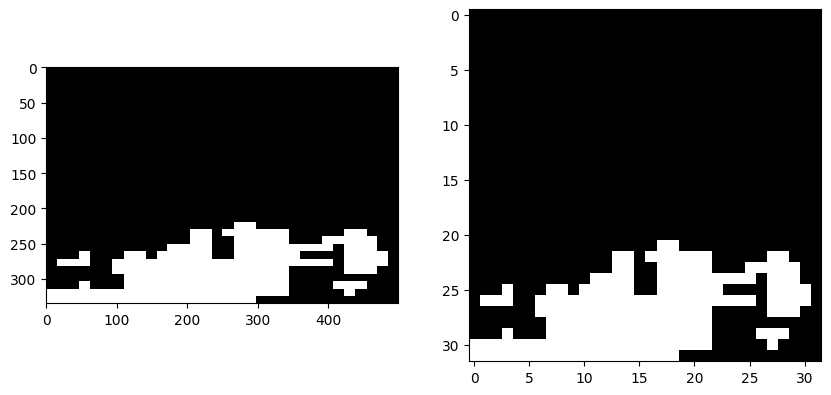

In [325]:
idx = 4
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
tmp = resized_masks[idx, 0]
axes[0].imshow(tmp, cmap='gray', interpolation='none')
axes[1].imshow(masks[idx], cmap='gray', interpolation='none')

tmp

In [ ]:

cluster_img = np.zeros((448, 448, 3))

for i in range(32):
    for j in range(32):
        patch_label = cluster_ids[i * 32 + j]
        # color = plt.cm.tab10(patch_label / 10)
        # cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = color[:3]
        cluster_img[i*14:(i+1)*14, j*14:(j+1)*14] = patch_label

# superpixels_masks.shape: (ids, C, H, W)
masks = []
for id in np.unique(cluster_ids):
    mask = (cluster_img == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks).permute(0, 3, 1, 2)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = torch.tensor(img.transpose(2, 0, 1))
img_repeated = T.Resize((448, 448))(img)[None].expand_as(masks)

In [ ]:
print (cluster_ids[..., None].shape)
np.tile(cluster_ids[..., None], (1, 1, 3)).shape

torch.Size([6, 3, 32, 32])
torch.Size([32, 32])
12


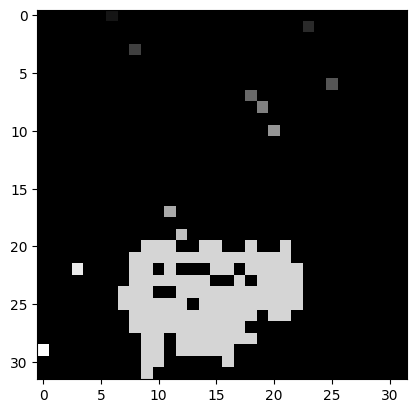

In [153]:
# masks.shape
# import torchvision.transforms.functional as TF
# resized = TF.resize(masks, (img.shape[1], img.shape[2]))
# resized = resized[0, 1].numpy()
# resized.shape


masks = []
for id in np.unique(cluster_ids):
    mask = (cluster_ids == id)
    masks.append(torch.tensor(mask))
masks = torch.stack(masks).permute(0, 3, 1, 2)

structure = [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]

structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]

print (masks.shape)

def reconstruct_mask(mask):
    pass

a = np.array([[0,0,1,1,0,0],
              [0,0,0,1,0,0],
              [1,1,0,0,1,0],
              [0,0,0,1,0,0]])
l, n = label(masks[2, 0], structure=structure)
plt.imshow(l, cmap='gray', interpolation='none')

tmp = masks[2, 0]
print (tmp.shape)
for lbl in range(1, n + 1):
    if np.sum(lbl == l) <= 3:
        # print (lbl)
        masks[2, 0][lbl == l] = 0
print (n)

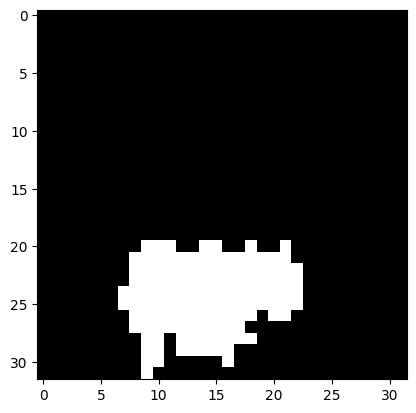

In [154]:
structure = [
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
]
reversed_mask = masks[2, 0].logical_not()
l, n = label(reversed_mask, structure=structure)

for lbl in range(1, n + 1):
    if np.sum(lbl == l) <= 3:
        # print (lbl)
        masks[2, 0][lbl == l] = 1

plt.imshow(masks[2, 0], cmap='gray', interpolation='none')

In [28]:
# Recursive
def dfs(matrix, i, j):
    if i < 0 or i >= len(matrix) or j < 0 or j >= len(matrix[0]) or matrix[i][j] != 1:
        return 0
    # Mark the cell as visited
    matrix[i][j] = -1
    size = 1  # current cell
    # visit all neighbors
    for row in range(i-1, i+2):
        for col in range(j-1, j+2):
            if (row != i or col != j) and (0 <= row < len(matrix)) and (0 <= col < len(matrix[0])):
                size += dfs(matrix, row, col)
    return size

# Iterative
def dfs(matrix, i, j):
    stack = [(i, j)]
    size = 0
    while stack:
        x, y = stack.pop()
        if 0 <= x < matrix.shape[0] and 0 <= y < matrix.shape[1] and matrix[x][y] == 1:
            size += 1
            matrix[x][y] = -1
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if dx != 0 or dy != 0:
                        stack.append((x + dx, y + dy))
    return size    

def remove_single_islands(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] == 1:
                # Start DFS if the cell is 1
                size = dfs(matrix, i, j)
                # If the island size is 1, change the original matrix cell to 0
                if size == 1:
                    matrix[i][j] = 0
                else:
                    # Restore the visited cells
                    restore_visited(matrix, i, j)
    return matrix

def restore_visited(matrix, i, j):
    if i < 0 or i >= len(matrix) or j < 0 or j >= len(matrix[0]) or matrix[i][j] != -1:
        return
    matrix[i][j] = 1  # restore cell
    # visit all neighbors
    for row in range(i-1, i+2):
        for col in range(j-1, j+2):
            if (row != i or col != j) and (0 <= row < len(matrix)) and (0 <= col < len(matrix[0])):
                restore_visited(matrix, row, col)


print(remove_single_islands(resized))

RecursionError: maximum recursion depth exceeded in comparison

In [2]:
color = torch.tensor([[255, 0, 0], [0, 255, 0], [0, 0, 255]]) # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

mask_imgs = torch.zeros_like(img_repeated)
remain_imgs = torch.zeros_like(img_repeated)
mask_imgs[masks] = img_repeated[masks]
remain_imgs[masks.logical_not()] = img_repeated[masks.logical_not()]

# Render images
# Mix-up (Background brightness unchanged)
color_mode = 'G'
if color_mode == 'R':
    rendered_imgs = (mask_imgs * 0.6 + masks * Red * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Red * 0.4
elif color_mode == 'G':
    rendered_imgs = (mask_imgs * 0.6 + masks * Green * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Green * 0.4
elif color_mode == 'B':
    rendered_imgs = (mask_imgs * 0.6 + masks * Blue * 0.4) + remain_imgs
    # rendered_imgs = img_repeated * 0.6 + masks * Blue * 0.4
else:
    raise ValueError('Color not supported: {}'.format(color_mode))

NameError: name 'torch' is not defined

In [21]:
pred = cv2.imread('/remote-home/zhangjiacheng/RVP/data/sem_seg_preds/scikit30/G/2007_001175.jpg')
# pred = np.array(Image.open('/remote-home/zhangjiacheng/RVP/data/sem_seg_preds/scikit30/G/2007_001175.jpg'))
# print (pred.shape)
# print (pred[..., 0])
# for i in range(pred.shape[0]):
#     print (pred[i])
print (np.unique(pred))
pred1 = np.load('./test.npy')
print (np.unique(pred1))
pred1[None].shape

[ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23]
[ 0 18]


(1, 375, 500)

In [8]:
cluster_ids

torch.Size([6, 3, 448, 448])